# Multiple Observation SocialDilemma

> Class for a symmetric two-agent stateless social dilemma environment

Typical examples are the *Prisoner's Dilemma*, *Stag Hunt* game, and the game of *chicken*/*snowdrift*/*hawk-dove*.

In [33]:
#| default_exp Environments/MultipleObsSocialDilemma

In [34]:
#| hide
# Imports for the nbdev development environment
from nbdev.showdoc import *

In [35]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
#| export
from pyCRLD.Environments.Base import ebase

from fastcore.utils import *
from fastcore.test import *

from pyCRLD.Environments.HeterogeneousObservationsEnv import HeterogeneousObservationsEnv

import numpy as np

In [37]:
#| export
class MultipleObsSocialDilemma(HeterogeneousObservationsEnv):
    """
    Symmetric 2-agent 2-action Social Dilemma Matrix Game.
    """
    def __init__(self,
                 rewards,  # rewards of mutual cooperation
                 temptations,  # temptations of unilateral defection
                 suckers_payoffs,  # sucker's payoff of unilateral cooperation
                 punishments,  # punishment of mutual defection
                 pC=0.5,
                 observation_opacity=None):

        # Normalize inputs to be lists of length 2
        self.rewards = [rewards, rewards] if isinstance(rewards, int) else rewards
        self.temptations = [temptations, temptations] if isinstance(temptations, int) else temptations
        self.suckers_payoffs = [suckers_payoffs, suckers_payoffs] if isinstance(suckers_payoffs, int) else suckers_payoffs
        self.punishments = [punishments, punishments] if isinstance(punishments, int) else punishments

        # Ensuring all are lists of size 2 for consistency
        if not all(len(lst) == 2 for lst in [self.rewards, self.temptations, self.suckers_payoffs, self.punishments]):
            raise ValueError("All parameters must either be a single integer or a list of two integers.")

        # TODO: these variables are expected to be already initialized in the parent class
        # causing a recursive calling and causing the dependency on them to fail
        # therefore we need to initialize them here
        self.n_agents = 2
        self.n_agent_actions = 2
        self.n_states = 2 # TODO: I'm not entirely sure on why we have 2 states here
        

        self.pC = pC  # prop. contract TODO: no idea what this is    
        self.state = 0 # initial state
        super().__init__(observation_opacity=observation_opacity)


In [38]:
#| export
@patch
def transition_tensor(self:MultipleObsSocialDilemma):
    """Calculate the Transition Tensor"""
    Tsas = np.ones((2, 2, 2, 2)) * (-1)
    Tsas[:, :, :, 0] = 1 - self.pC
    Tsas[:, :, :, 1] = self.pC
    return Tsas

@patch
def reward_tensor(self:MultipleObsSocialDilemma):
    """Get the Reward Tensor R[i,s,a1,...,aN,s']."""

    R = np.zeros((self.n_agents, self.n_states, self.n_agent_actions, self.n_agent_actions, self.n_states))

    # TODO: the way these arrays are defined is invalid code and I dont want to figure out why

    # TODO: in general i don't understand the construction of these arrays. What does : do anyway?
    # ok so the cmd above creates two arrays (n_agents) of a two dimensional space that is indicating the number
    # of states, for each action an agent can take... So we have one matrix that contains all actions C 
    # and another matrix containing all actions D. So I'm assuming a game can be in either C state or D state?
    # though I thought IPD only had one state '.'. This is where my confusion lies.
    # I also don't fully understand how these arrays are filled. I should print R and check.
    
    # set reward matrix for agent 0
    R[0, 0, :, :, 0] = [[self.rewards[0], self.suckers_payoffs[0]],
                        [self.temptations[0], self.punishments[0]]]
    R[1, 0, :, :, 0] = [[self.rewards[0], self.temptations[0]],
                        [self.suckers_payoffs[0], self.punishments[0]]]
    R[:, 0, :, :, 1] = R[:, 0, :, :, 0]

    # set reward matrix for agent 1 in the second state
    R[0, 1, :, :, 1] = [[self.rewards[1], self.suckers_payoffs[1]],
                        [self.temptations[1], self.punishments[1]]]
    R[1, 1, :, :, 1] = [[self.rewards[1], self.temptations[1]],
                        [self.suckers_payoffs[1], self.punishments[1]]]
    R[:, 1, :, :, 0] = R[:, 1, :, :, 1]
    
    return R

@patch
def actions(self:MultipleObsSocialDilemma):
    """The action sets"""
    return [['c', 'd'] for _ in range(self.n_agents)]

@patch
def states(self:MultipleObsSocialDilemma):
    """The states set"""
    return [0, 1], ["no contract", "contract"] # TODO: I don't understand why we use 2 states?

@patch
def id(self:MultipleObsSocialDilemma):
    """
    Returns id string of environment
    """
    # Default
    id = f"{self.__class__.__name__}_"+\
        f"{self.temptations}_{self.rewards}_{self.punishments}_{self.suckers_payoffs}"
    return id

### Example

In [39]:
env_full_obs = MultipleObsSocialDilemma(rewards=1, temptations=2, suckers_payoffs=-1, punishments=0, observation_opacity=[0, 1])

TypeError: HeterogeneousObservationsEnv.__init__() got an unexpected keyword argument 'observation_opacity'

In [8]:
env_full_obs.observations

array([[[1. , 0. ],
        [0. , 1. ]],

       [[0.5, 0.5],
        [0.5, 0.5]]])

In [9]:
env_full_obs.rewards

array([[[[[ 1.,  1.],
          [-1., -1.]],

         [[ 2.,  2.],
          [ 0.,  0.]]],


        [[[ 1.,  1.],
          [-1., -1.]],

         [[ 2.,  2.],
          [ 0.,  0.]]]],



       [[[[ 1.,  1.],
          [ 2.,  2.]],

         [[-1., -1.],
          [ 0.,  0.]]],


        [[[ 1.,  1.],
          [ 2.,  2.]],

         [[-1., -1.],
          [ 0.,  0.]]]]])

In [10]:
env_full_obs.observation_labels

[['0', '1'], ['0', '1']]

In [11]:
from pyCRLD.Agents.POStrategyActorCritic import POstratAC
from pyCRLD.Utils import FlowPlot as fp
env_fullObs = MultipleObsSocialDilemma(rewards=[5,5], temptations=[6,2], suckers_payoffs=[-1,-1], punishments=[0, 0], pC=0.5, observation_opacity=[0,1])
mae_fullObs = POstratAC(env=env_fullObs, learning_rates=0.1, discount_factors=0.9)

for agent  0
confidence is , 0
2 2 2
for agent  1
confidence is , 1
2 2 2


array([<Axes: title={'center': 'Cond. 0'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">,
       <Axes: title={'center': 'Cond. 1'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">],
      dtype=object)

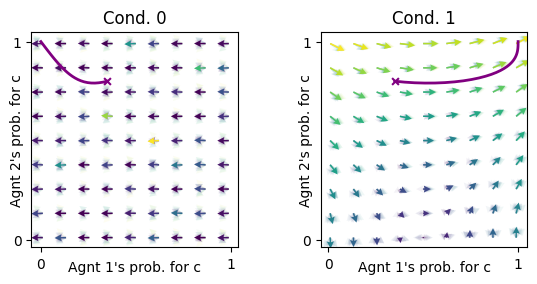

In [12]:
pc00, pc01, pc10, pc11 = 0.35, 0.35, 0.8, 0.8
X = [[[pc00, 1-pc00],     #initial policy to visulize learning trajectory
      [pc01, 1-pc01]], 
     [[pc10, 1-pc10], 
      [pc11, 1-pc11]]] 
X = np.array(X)
xtraj, fixedpointreached = mae_fullObs.trajectory(X)

x = ([0], [0,1], [0])  # Plotting on the x-axis the [0]'s agents probability in both observations [0,1] to cooprate [0]
y = ([1], [0,1], [0])  # Plotting on the y-axis the [1]'s agents probability in both observations [0,1] to cooprate [0]
ax = fp.plot_strategy_flow(mae_fullObs, x, y, flowarrow_points = np.linspace(0.01 ,0.99, 9), NrRandom=16)
fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes=ax)

In [13]:
dir(mae_fullObs.env.Aset)

['__add__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

In [14]:
env_fullObs.Sset = ['.', '.']

In [27]:
from pyCRLD.Environments.HistoryEmbedding import HistoryEmbedded
env_fullObs = MultipleObsSocialDilemma(rewards=[5,5], temptations=[6,2], suckers_payoffs=[-1,-1], punishments=[0, 0], pC=0.5, observation_opacity=[0,1])
env_fullObs.Sset = ['.', '.']
memo1pd = HistoryEmbedded(env_fullObs, h=(1,1,1))
# memo1pd.Sset

for agent  0
confidence is , 0
2 2 2
for agent  1
confidence is , 1
2 2 2


In [28]:
env_fullObs.Sset

['.', '.']

In [29]:
env_fullObs.Q

2

In [30]:
memo1pd.Sset

['c,c,.|',
 'c,c,.|',
 'c,d,.|',
 'c,d,.|',
 'd,c,.|',
 'd,c,.|',
 'd,d,.|',
 'd,d,.|']

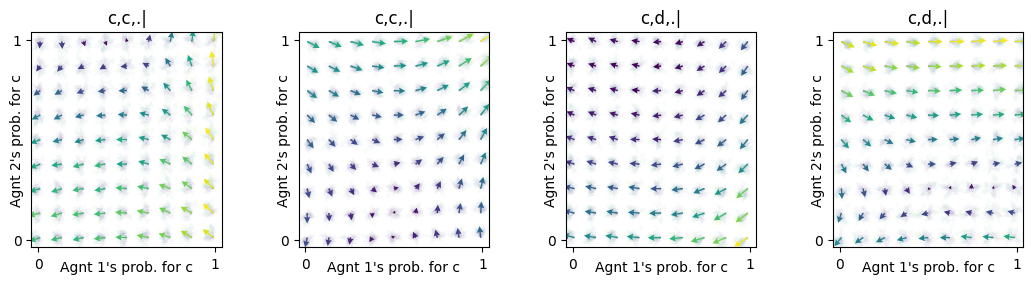

In [32]:
# mae1 = stratAC(env=memo1pd, learning_rates=0.1, discount_factors=0.9)
mae_fullObs = POstratAC(env=memo1pd, learning_rates=0.1, discount_factors=0.9)
x = ([0], [0,1,2,3], [0])
y = ([1], [0,1,2,3], [0])
ax = fp.plot_strategy_flow(mae_fullObs, x, y, flowarrow_points=np.linspace(0.01 ,0.99, 9), NrRandom=32,
                           conds=mae_fullObs.env.Sset)


In [ ]:
env_full_obs.id()

In [ ]:
env_full_obs

Reward matrix of agent `0`:

Reward matrix of agent `1`:

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()